In [ ]:
import math, os
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import meep as mp
import meep.adjoint as mpa
from meep.materials import Ag
import matplotlib.pyplot as plt

# ----------------------------
# 전역 파라미터 (Meep 예제와 동일)
# ----------------------------
resolution = 50      # px/µm
nfreq      = 100
fcen       = 1.0
df         = 0.2
frequencies = np.linspace(fcen - 0.5*df, fcen + 0.5*df, nfreq)

dpml = 1.0
dair = 2.0
hrod = 0.7     # 텍스처(디자인) 높이
# wrod = 0.5     # 텍스처(디자인) 폭
wrod = 1.0     # 텍스처(디자인) 폭
dsub = 5.0
dAg  = 0.5

sx = 1.1
sy = dpml + dair + hrod + dsub + dAg
cell_size = mp.Vector3(sx, sy)

substrate = mp.Medium(index=3.45)
air       = mp.Medium(index=1.0)

pml_layers = [mp.PML(direction=mp.Y, thickness=dpml, side=mp.High)]  # 상부에만 PML

# ----------------------------
# 디자인 영역 설정 (MaterialGrid)
# ----------------------------
DESIGN_W  = wrod
DESIGN_H  = hrod
design_c  = mp.Vector3(0, 0.5*sy - dpml - dair - 0.5*hrod)  # 상단 air 바로 아래 텍스처 위치
design_sz = mp.Vector3(DESIGN_W, DESIGN_H)

design_res = resolution
NX = int(DESIGN_W * design_res) + 1
NY = int(DESIGN_H * design_res) + 1
# NY = 1
n_vars = NX * NY

# 최소 피쳐/이진화 설정
MIN_FEATURE = 0.08    # ~80 nm
eta_i = 0.5
beta  = 8
beta_scale = 2
num_beta_steps = 3
filter_radius = mpa.get_conic_radius_from_eta_e(MIN_FEATURE, 0.55)

# 초기 디자인 변수 (0..1)
x = np.ones((n_vars,), dtype=float) * 0.5

# MaterialGrid 준비: 공기(0)↔기판(1) 보간
design_vars = mp.MaterialGrid(
    mp.Vector3(NX, NY, 0),
    air, substrate,
    grid_type="U_MEAN",
)
design_region = mpa.DesignRegion(design_vars, volume=mp.Volume(center=design_c, size=design_sz))

# ----------------------------
# geometry (디자인 포함)
# ----------------------------
geometry = [
    # Substrate bulk
    mp.Block(
        material=substrate,
        center=mp.Vector3(0, 0.5*sy - dpml - dair - hrod - 0.5*dsub),
        size=mp.Vector3(mp.inf, dsub, mp.inf),
    ),
    # Ag back reflector
    mp.Block(
        material=Ag,
        center=mp.Vector3(0, -0.5*sy + 0.5*dAg),
        size=mp.Vector3(mp.inf, dAg, mp.inf),
    ),
    # Design block (텍스처 영역)
    mp.Block(
        material=design_vars,
        center=design_region.center,
        size=design_region.size,
    ),
]

# ----------------------------
# 목표 각도/가중치 (법선 1개 예시)
#  - 다중 각도면 TARGET_ANGLES_DEG = [0, 20, -20], ANGLE_WEIGHTS=[0.5, 0.25, 0.25] 처럼 확장
# ----------------------------
TARGET_ANGLES_DEG = [0.0]
ANGLE_WEIGHTS     = [1.0]

# ----------------------------
# backward_source(공기측) → Forward_source 층(기판 내부 라인)에서 DFT|Ez|^2 측정
# 각도별 OptimizationProblem을 미리 구성 (같은 design_region 공유)
# ----------------------------
problems = []
for theta_deg in TARGET_ANGLES_DEG:
    theta = math.radians(theta_deg)

    # backward_source: 상단 air에서 아래(-y)로 진행하는 선형 소스(넓은 라인) + broadband
    backward_source = [mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(0, 0.5*sy - dpml),
        size=mp.Vector3(sx, 0)
    )]

    # k_point 설정: broadband 유지용 (문서 가이드) — fmin 기준
    fmin = float(np.min(frequencies))
    n_top = 1.0
    kx = n_top * fmin * math.sin(theta)
    k_point = mp.Vector3(kx, 0, 0) if abs(theta) > 1e-9 else mp.Vector3()

    sim = mp.Simulation(
        cell_size=cell_size,
        resolution=resolution,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=backward_source,
        k_point=k_point
    )

    # Forward_source 층: 기판 내부 라인에서 DFT 필드 샘플
    Forward_source_line_center = mp.Vector3(0, -0.5*sy + dAg + 0.5*dsub)
    Forward_source_line_size   = mp.Vector3(sx, 0, 0)

    FF = mpa.FourierFields(sim, mp.Volume(center=Forward_source_line_center, size=Forward_source_line_size), mp.Ez)

    # 목적함수: 라인 전체·대역 평균 |Ez|^2 (lambda로 직접 기입)
    J_lambda = lambda fields: npa.mean(npa.abs(fields)**2, axis=1)

    opt = mpa.OptimizationProblem(
        simulation=sim,
        objective_functions=[J_lambda],
        objective_arguments=[FF],
        design_regions=[design_region],
        frequencies=frequencies,
        maximum_run_time=4000,
    )
    problems.append(opt)


     block, center = (0,-1.6,0)
          size (1e+20,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-4.35,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.25,0)
          size (1,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)


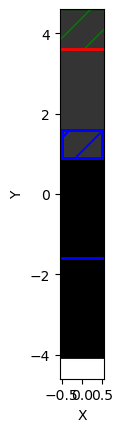

In [17]:
opt.plot2D(True)

In [18]:
# ----------------------------
# 맵핑(필터 → 프로젝션) 정의: lambda로 작성
# ----------------------------
map_weights = lambda x_flat, eta, b: mpa.conic_filter(
    x_flat.reshape(NX, NY),
    filter_radius, DESIGN_W, DESIGN_H, design_res
).flatten()

# ----------------------------
# 간단 Adam(경사상승) 하이퍼파라미터
# ----------------------------
lr = 0.15
beta1, beta2 = 0.9, 0.999
eps = 1e-8
max_iters_per_beta = 30

m = np.zeros_like(x)
v = np.zeros_like(x)
t = 0

history = []

# ----------------------------
# 베타-스케줄 루프 (이진화 강화)
# ----------------------------
for _ in range(num_beta_steps):
    design_vars.beta = beta
    design_vars.do_averaging = True

    for it in range(max_iters_per_beta):
        # 맵핑 적용 (필터+프로젝션)
        u = map_weights(x, eta_i, beta)

        # 각도별 목적/그래디언트 합산
        total_J = 0.0
        total_dJdu = np.zeros((n_vars,), dtype=float)

        for w, opt in zip(ANGLE_WEIGHTS, problems):
            Jval, dJ_du_list = opt([u])      # forward+adjoint 자동 수행
            dJ_du = dJ_du_list[0].reshape(-1)  # 단일 design_region

            total_J   += w * float(np.real(Jval))
            total_dJdu += w * np.real(dJ_du)

        # 체인룰: dJ/dx = (dJ/du) · (du/dx)  → VJP로 계산 (autograd tensor_jacobian_product)
        dJ_dx = tensor_jacobian_product(map_weights, 0)(x, eta_i, beta, total_dJdu)

        # Adam 경사상승 업데이트
        t += 1
        m = beta1 * m + (1 - beta1) * dJ_dx
        v = beta2 * v + (1 - beta2) * (dJ_dx * dJ_dx)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        step = lr * m_hat / (np.sqrt(v_hat) + eps)
        x = np.clip(x + step, 0.0, 1.0)

        if mp.am_master():
            print(f"[beta={beta:>5.2f}] iter {it+1:02d}/{max_iters_per_beta}  J={total_J:.6f}")

        history.append(total_J)

    beta *= beta_scale  # 이진화 강화

# ----------------------------
# 결과 저장/시각화
# ----------------------------
final_u = map_weights(x, eta_i, beta / beta_scale)  # 마지막 step 이전 beta로 투영
np.save("optimized_weights.npy", final_u.reshape(NX, NY))
if mp.am_master():
    print("Done. Best J =", history[-1])
    print("Saved: optimized_weights.npy")

    plt.figure(figsize=(5,4))
    plt.imshow(final_u.reshape(NX, NY).T, origin='lower', aspect='auto', extent=[-DESIGN_W/2, DESIGN_W/2, -DESIGN_H/2, DESIGN_H/2])
    plt.colorbar(label='Material weight (0=air, 1=substrate)')
    plt.title("Optimized Design (MaterialGrid)")
    plt.tight_layout()
    plt.savefig("optimized_design.png", dpi=200)
    plt.close()

    plt.figure(figsize=(6,3))
    plt.plot(history)
    plt.xlabel("Iteration")
    plt.ylabel("Objective ⟨|Ez|²⟩ at Forward_source layer")
    plt.tight_layout()
    plt.savefig("history.png", dpi=200)
    plt.close()


Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 2D dimensions.
Computational cell is 1.1 x 9.2 x 0 with resolution 50
     block, center = (0,-1.6,0)
          size (1e+20,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-4.35,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.25,0)
          size (1,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.030127 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.658148, gamma=3.13427
drude susceptibility: frequency=1

TypeError: only length-1 arrays can be converted to Python scalars